##  Travel time prediction in Indian Metro cities using Uber Movement data and OpenStreetMap


Uber provides anonymized and aggregated travel time data through [Uber Movement](https://movement.uber.com/) platform for many citites across the world. For India, current and historic data is available for 5 cities - Bangalore, Hyderabad, New Delhi, Mumbai and Kolkata. It also provides the details on the ward boundaries in the form of JSON file.

[OpenStreetMap](https://wiki.openstreetmap.org/wiki/About_OpenStreetMap) (OSM) is a free, editable map of the whole world that is being built by volunteers largely from scratch and released with an open-content license. OSM data includes a global navigable street network dataset. Several services exists that provide routing and network analysis on top of this data. 

In this project, we use the open travel time dataset from Uber and leverage open-source routing services for OpenStreetMap to build a fairly accurate model for travel time within each of the metro cities in India. We show that by using rich ecosystem of Python Geospatial libraries, we can easily consume, process, and visualize large amount of geospatial data easily and incorporate it easily into a machine learning model.

**Open datasets**
- Uber Movement - Travel times and ward boundaries
- OpenStreetMap

**Python libraries**
- geopandas
- shapely
- matplotlib
- folium
- sklearn

**Services**
- Open Source Routing Machine (OSRM)
- OpenRouteService (ORS) API 

In [39]:
import pandas as pd
import geopandas as gpd
import requests
import shapely
import matplotlib.pyplot as plt
import datetime
import os
%matplotlib inline

## Reading Datasets

### Travel Times

In [9]:
data_folder = os.path.join('data', 'uber')

The Uber Movement Travel Times data comes as a CSV file for each quarter. Here we are using the **Travel Times By Date By Hour Buckets (All Days)** dataset. This data set includes the arithmetic mean, geometric mean, and standard deviations for aggregated travel times between every ward in the city, for every day of the quarter and aggregated into time categories. This is a large dataset with over **7M rows**.

We import the data as a Pandas DataFrame and call `convert_dtypes()` to select the best datatypes for each column. 

In [10]:
travel_times_file = 'bangalore-wards-2020-1-All-DatesByHourBucketsAggregate.csv'
travel_times_filepath = os.path.join(data_folder, travel_times_file)
travel_times= pd.read_csv(travel_times_filepath)
travel_times = travel_times.convert_dtypes()

In [8]:
travel_times

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,102,97,3,13,10,16,322.80,425.14,270.59,1.70
1,98,55,2,11,0,7,933.90,194.85,915.32,1.22
2,148,111,1,11,16,19,1861.08,317.79,1836.22,1.17
3,58,22,2,8,16,19,1463.30,455.25,1391.25,1.38
4,54,62,1,18,16,19,701.49,320.39,634.64,1.56
...,...,...,...,...,...,...,...,...,...,...
7648072,100,109,3,6,10,16,794.02,161.94,779.03,1.21
7648073,169,173,1,25,0,7,2539.70,317.88,2519.15,1.14
7648074,71,52,3,5,10,16,1072.40,273.84,1043.70,1.25
7648075,85,140,1,26,19,0,1298.86,347.86,1253.28,1.31


### Ward Boundaries

The travel times dataset contain details of travel between *Zones*. For Indian citites, the zones are **Wards** as defined by the local municipal corporation. This data comes as a **GeoJSON** file that contains the polygon representation of each ward. We use `geopandas` to read the file as a GeoDataFrame.

In [12]:
wards_file = 'bangalore_wards.json'
wards_filepath = os.path.join(data_folder, wards_file)
wards = gpd.read_file(wards_filepath)

In [13]:
wards

,WARD_NO,WARD_NAME,MOVEMENT_ID,DISPLAY_NAME,geometry
0,2,Chowdeswari Ward,1,"Unnamed Road, Bengaluru","MULTIPOLYGON (((77.59229 13.09720, 77.59094 13..."
1,3,Atturu,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...","MULTIPOLYGON (((77.56862 13.12705, 77.57064 13..."
2,4,Yelahanka Satellite Town,3,"15th A Cross Road, Yelahanka Satellite Town, Y...","MULTIPOLYGON (((77.59094 13.09842, 77.59229 13..."
3,51,Vijnanapura,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...","MULTIPOLYGON (((77.67683 13.01147, 77.67695 13..."
4,53,Basavanapura,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...","MULTIPOLYGON (((77.72899 13.02061, 77.72994 13..."
...,...,...,...,...,...
193,172,Madivala,194,"0 1st B Cross Road, Cashier Layout, 1st Stage,...","MULTIPOLYGON (((77.61399 12.92347, 77.61419 12..."
194,26,Ramamurthy Nagar,195,"Kalkere-Agara Main Road, Horamavu Agara, Kalke...","MULTIPOLYGON (((77.68336 13.05192, 77.68384 13..."
195,25,Horamavu,196,"0 Horamavu Agara Main Road, 1st Block, Mallapp...","MULTIPOLYGON (((77.64931 13.07853, 77.64993 13..."
196,86,Marathahalli,197,"0 3rd Cross Road, Manjunatha Layout, Marathaha...","MULTIPOLYGON (((77.68549 12.94121, 77.68539 12..."


<AxesSubplot:>

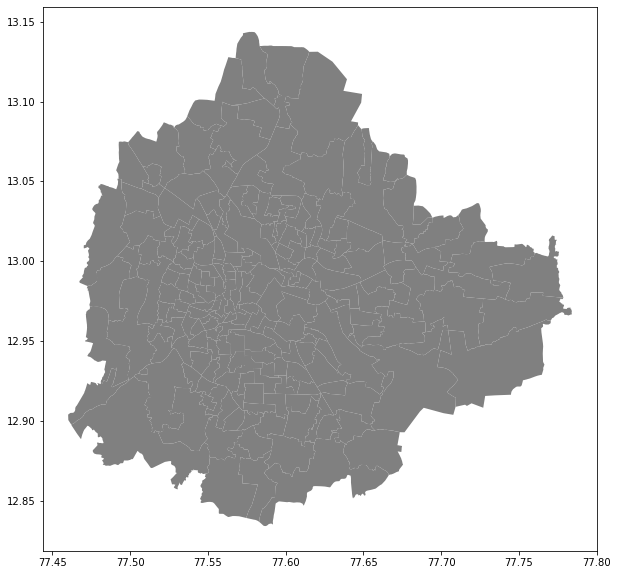

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
wards['geometry'].plot(color='grey',ax=ax)

## Data Pre-Processing

### Travel Times

The source data contains the travel times grouped by blocks of time (peak/off-peak etc.), defined by `start_hour` and `end_hour` columns. To allow us to model this easily, we add a `time_period` columns and assign an integer category value. 

In [20]:
categories_to_hour = {
    1: [0, 6],
    2: [7, 9],
    3: [10, 15],
    4: [16, 18],
    5: [19, 23]
}

def get_time_period(hour):
    for category, (start_hour, end_hour) in categories_to_hour.items():
        if hour >= start_hour and hour <= end_hour:
            return category

In [21]:
travel_times['time_period'] = travel_times['start_hour'].apply(get_time_period)

Travel time has a strong correlation with the day of the week. So we compute a new column `dow` from the day and month columns

In [24]:
year = 2020

def get_dow(row):
    return datetime.date(year, row['month'], row['day']).weekday()

In [25]:
travel_times['dow'] = travel_times.apply(get_dow, axis=1)

In [26]:
travel_times

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,time_period,dow
0,102,97,3,13,10,16,322.80,425.14,270.59,1.70,3,4
1,98,55,2,11,0,7,933.90,194.85,915.32,1.22,1,1
2,148,111,1,11,16,19,1861.08,317.79,1836.22,1.17,4,5
3,58,22,2,8,16,19,1463.30,455.25,1391.25,1.38,4,5
4,54,62,1,18,16,19,701.49,320.39,634.64,1.56,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
7648072,100,109,3,6,10,16,794.02,161.94,779.03,1.21,3,4
7648073,169,173,1,25,0,7,2539.70,317.88,2519.15,1.14,1,5
7648074,71,52,3,5,10,16,1072.40,273.84,1043.70,1.25,3,3
7648075,85,140,1,26,19,0,1298.86,347.86,1253.28,1.31,5,6


### Ward Boundaries

For modeling purposes, we use centroid of each ward to represent the ward. We use GeoPandas `centroid()` function to get the point geometry representing the centroid.

Our source data comes in the *EPSG:4326 WGS84 Geographic Projection* - which is not suitable forgeoprocessing operations. To get the accurate centroid computation, we must re-project the data to a *Planar Projection*. We use a UTM projection suitable for the region of the data - *WGS 84 UTM Zone 43N* - which is defined by the code [EPSG:32643](http://epsg.io/32643). Once computed, we transform it back to EPSG:4326 and add it to our GeoDataFrame.

In [32]:
centroid_utm = wards.geometry.to_crs('EPSG:32643').centroid
wards['centroid'] = centroid_utm.to_crs('EPSG:4326')

<AxesSubplot:>

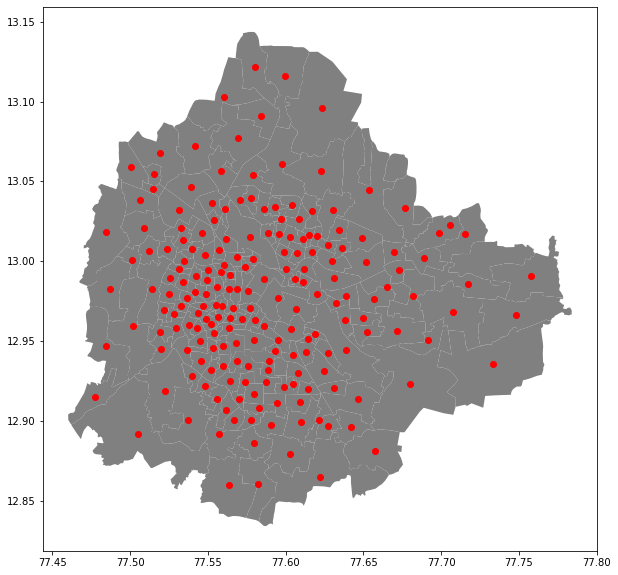

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
wards['geometry'].plot(color='grey',ax=ax)
wards['centroid'].plot(color='red',ax=ax)

## Distance Computation

We have the travel times for each pair of source and destination wards. The travel time is strongly correlated with the distance between the wards. We need to compute the actual distance along the road network for our ward.

In [81]:
ward_no = wards['MOVEMENT_ID']
index = pd.MultiIndex.from_product([ward_no, ward_no], names = ['sourceid', 'dstid'])

distancematrix = pd.DataFrame(index = index).reset_index()
distancematrix = distancematrix.query('sourceid != dstid')

In [82]:
def get_coordinates(row):
    source_ward = wards[wards['MOVEMENT_ID'] == row['sourceid']].iloc[0]
    dst_ward = wards[wards['MOVEMENT_ID'] == row['dstid']].iloc[0]

    src_lon, src_lat = source_ward['centroid'].x, source_ward['centroid'].y
    dst_lon, dst_lat = dst_ward['centroid'].x, dst_ward['centroid'].y
    return src_lon, src_lat, dst_lon, dst_lat

In [83]:
distancematrix[['src_lon', 'src_lat', 'dst_lon', 'dst_lat']] = distancematrix.apply(get_coordinates, axis=1, result_type='expand')

In [84]:
distancematrix

,sourceid,dstid,src_lon,src_lat,dst_lon,dst_lat
1,1,2,77.580422,13.121709,77.560037,13.102805
2,1,3,77.580422,13.121709,77.583926,13.090987
3,1,4,77.580422,13.121709,77.669565,13.006063
4,1,5,77.580422,13.121709,77.715456,13.016847
5,1,6,77.580422,13.121709,77.705502,13.022373
...,...,...,...,...,...,...
39198,198,193,77.505015,12.891903,77.594507,12.910882
39199,198,194,77.505015,12.891903,77.614418,12.920018
39200,198,195,77.505015,12.891903,77.676539,13.033613
39201,198,196,77.505015,12.891903,77.653272,13.044560


We need to get driving distance between approximately 40,000 coordinates. To do this efficiently, we ran the [Open Source Routing Machine (OSRM)](https://hub.docker.com/r/osrm/osrm-backend/) service locally using docker images provided by the project. OSRM holds the network graph in memory and the routing is extremely fast. We write and apply the following function and get the driving distance in meters.

In [87]:
def get_distance(src_lon, src_lat, dst_lon, dst_lat):
    
    coordinates = '{},{};{},{}'.format(src_lon, src_lat, dst_lon, dst_lat)
    url = 'http://127.0.0.1:5000/route/v1/driving/'
    response = requests.get(url + coordinates) 
    if response.status_code== 200:
        data = response.json()   
        distance = data['routes'][0]['distance']
    
    return distance

The resulting distance data is saved locally and used in the subsequent analysis.

In [88]:
osrm_data_folder = os.path.join('data', 'osrm')
distancematrix_file = 'distancematrix.csv'
distancematrix_filepath = os.path.join(osrm_data_folder, distancematrix_file)
distancematrix = pd.read_csv(distancematrix_filepath)

In [89]:
distancematrix

,sourceid,dstid,src_lon,src_lat,dst_lon,dst_lat,distance
0,1,2,77.580422,13.121709,77.560038,13.102805,4695.5
1,1,3,77.580422,13.121709,77.583925,13.090987,4219.8
2,1,4,77.580422,13.121709,77.669565,13.006063,20677.6
3,1,5,77.580422,13.121709,77.715456,13.016847,26302.8
4,1,6,77.580422,13.121709,77.705493,13.022376,24392.8
...,...,...,...,...,...,...,...
39001,198,193,77.505013,12.891903,77.594507,12.910882,12920.0
39002,198,194,77.505013,12.891903,77.614418,12.920018,15970.4
39003,198,195,77.505013,12.891903,77.676539,13.033613,29318.0
39004,198,196,77.505013,12.891903,77.653271,13.044561,28626.5
